# Analysis: ICE detainers in Travis County, Texas
This notebook has the scripts to parse and analyze data returned in response to a Statesman request for ICE detainer records in Travis County, Texas.

The sheriff's office posts [PDFs of daily reports](https://www.tcsheriff.org/inmate-jail-info/ice-listing) generated by its database software, but the Statesman requested, and received, a spreadsheet version of these reports in early October 2016.

The spreadsheet of raw data lives at `raw_data/ICE - Detainer Added.xlsx`. There's also a file of lookups to help standardize the data at `./lookups.py`.

Note: This notebook begins with a bash script that transforms the spreadsheet into a CSV and chops some cruft from each end of the file, so this step probs won't work if you're on a Windows machine.

Pre-2006 data was excluded because it was less reliable.

In [1]:
# instantiate matplotlib ish
%matplotlib inline

In [2]:
%%bash

# use csvkit to turn the spreadsheet into a CSV
in2csv 'raw_data/ICE - Detainer Added.xlsx' > raw_data/data.csv

# trim six lines from the head and 10 from the tail
count=$(wc -l < raw_data/data.csv | sed 's/ //g'); trim=$(echo $count - 10 | bc); \
tail -n +6 raw_data/data.csv | head -n $trim > raw_data/trimmed_data.csv

# clean up intermediate file
rm -rf raw_data/data.csv

# report line count
wc -l < raw_data/trimmed_data.csv | sed 's/ //g'

53439


/Users/cjwinchester/Envs/ice-data/lib/python3.5/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


In [4]:
from __future__ import print_function

import csv
import datetime
from collections import Counter

import agate
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

from lookups import COUNTRIES, VIOLENT_CRIMES, FELONIES, MISDEMEANORS


def name_unmangler(name_str):
    """Return `LAST,REST` as a tuple"""
    try:
        name_split = name_str.split(',')
        return (name_split[0], name_split[1])
    except:
        return name_str

# scrape spreadsheet data into a python dictionary
with open('raw_data/trimmed_data.csv', 'r') as infile:
    data = csv.reader(infile, delimiter=',')

    # main dict to hold the data
    inmate_dict = {}

    # set initial defaults    
    new_record = False
    booking_id = None

    # start a list to eventually feed to a Counter
    # that will report charge frequency for us
    charge_list = []

    # start a list of how 'ICE DETAINER' records are coded
    # for data sanity purposes
    ice_codes = []
    
    # loop over spreadsheet data
    for row in data:
        
        # if new_record flag is True, add a new key to dict
        if new_record:
            booking_id = row[1].strip()
            name = row[2].strip()
            race = row[3].strip()
            sex = row[4].strip()
            age = row[6].strip()
            booking_date = row[7].strip()
            nativity = row[8].strip()

            # see if there's a clean country name
            try:
                nativity_clean = COUNTRIES[nativity]
            except:
                nativity_clean = nativity

            # get month and year as string for grouping purposes later
            month_year = booking_date[:7]
                
            # add this record to the dict
            inmate_dict[booking_id] = {
                'last_name': name_unmangler(name)[0],
                'rest_name': name_unmangler(name)[1],
                'race': race,
                'sex': sex,
                'age': age,
                'booking_date': booking_date,
                'month_year': month_year,
                'nativity': nativity,
                'nativity_clean': nativity_clean,
                'charges': [],
                'felonies': 0,
                'misdemeanors': 0,
                'violent_crimes': 0,
                'total_non_ice_charges': 0
            }
            
            # reset flag
            new_record = False
        else:
            # if it's not the line with bio data, it's that person's charges
            
            # try to retrieve record from dict
            rec = inmate_dict.get(booking_id, None)

            if rec:    
                # after bio data come lines of charge info
                # make sure it's not a subhead row, or empty
                if ''.join(row).strip() != '' and row[1].strip() != 'Charge':
                    charge = {}
                    charge['charge_id'] = row[1].strip()
                    charge['charge_description'] = row[2].strip()
                    charge['charge_level'] = row[3].strip()
                    charge['sentence'] = row[4].strip()
                    charge['disposition_date'] = row[6].strip()
                    charge['disposition_description'] = row[8].strip()
                    rec['charges'].append(charge)

                    # add to frequency list
                    charge_list.append(row[2].strip())

                    # if DETAINER charge, add to ice codes list
                    if row[2].strip() == 'ICE DETAINER':
                        ice_codes.append(row[2].strip())
                    else:
                        # otherwise, increment non-ice-detainer charges counter
                        rec['total_non_ice_charges'] += 1
                    
                    # if felony, increment felony counter for this detainee
                    if row[3].strip() in FELONIES and row[2].strip().upper() != 'ICE DETAINER':
                        rec['felonies'] += 1
                    
                    # if misdemeanor, increment misdemeanors counter
                    if row[3].strip() in MISDEMEANORS and row[2].strip().upper() != 'ICE DETAINER':
                        rec['misdemeanors'] += 1

                    # if violent crime, increment violent crime counter
                    if row[2].strip() in VIOLENT_CRIMES and row[2].strip().upper() != 'ICE DETAINER':
                        rec['violent_crimes'] += 1
                        
        # if it's a blank row, the next one is a new record
        if ''.join(row).strip() == '' or row[1] == 'Booking No':
            # set flag
            new_record = True
            
    print('who\'s got two thumbs and a dict with', len(inmate_dict), 'keys')
    print('you do that\'s who')

who's got two thumbs and a dict with 9533 keys
you do that's who


### Load data into Agate for basic analysis

In [5]:
# set up an empty list to turn into an Agate table
rows = []

# define column names and types
column_names = ['booking_id', 'booking_date', 'booking_month_year', 'nativity', 'sex',
                'age', 'race', 'felony', 'misdemeanor', 'violent_crime', 'total_non_ice_charges']

column_types = [agate.Text(), agate.Date(), agate.Text(), agate.Text(), agate.Text(), 
                agate.Number(), agate.Text(), agate.Number(), agate.Number(),
                agate.Number(), agate.Number()]

# spin through that dictionary
for key in inmate_dict:
    rows.append([
        key,
        inmate_dict[key]['booking_date'],
        inmate_dict[key]['month_year'],
        inmate_dict[key]['nativity_clean'],
        inmate_dict[key]['sex'],
        inmate_dict[key]['age'],
        inmate_dict[key]['race'],
        inmate_dict[key]['felonies'],
        inmate_dict[key]['misdemeanors'],
        inmate_dict[key]['violent_crimes'],
        inmate_dict[key]['total_non_ice_charges']
    ])
    
# load data into an Agate table
table = agate.Table(rows, column_names, column_types).order_by('booking_date', reverse=True).where(
    # filter out pre-2006 records
    lambda row: row['booking_date'].year >= 2006
)
    
# most common charges
most_common_charges = Counter(charge_list).most_common(11)

# list of charge levels associated with detainers (used to clarify a couple of data issues)
ice_codes = list(set(ice_codes))

print('##############################################')
print('# SUMMARY STATS, JAN. 1, 2006 - OCT. 4, 2006 #')
print('##############################################\n')

# get most common charges
print('10 most common charges')
print('----------------------')

for charge in most_common_charges:
    print(charge[0] + ":", '{:,}'.format(charge[1]))

print('\n* Total number of detainees:', '{:,}'.format(len(table.rows)), "\n")

# get summary stats for felonies and violent crimes
subset_categories = ('felony', 'violent_crime')

for category in subset_categories:
    
    # filter table for "at least one"
    cat_table = table.where(
        lambda row: row[category] > 0
    )

    # get percentage of total
    pct_with_cat = '{:.2%}'.format(len(cat_table.rows) / len(table.rows))
    
    print('* Detainees with at least 1', category + ':', '{:,}'.format(len(cat_table.rows)),
          '(' + pct_with_cat + ')')

    # filter table for "more than one"
    multi_cat_table = table.where(
        lambda row: row[category] > 1
    )

    # get percentage of total
    multi_pct_with_cat = '{:.2%}'.format(len(multi_cat_table.rows) / len(table.rows))
    
    print('* Detainees with more than 1', category + ':', '{:,}'.format(len(multi_cat_table.rows)),
          '(' + multi_pct_with_cat + ')\n')

with_only_one_misdemeanor = table.where(
    lambda row: row['felony'] == 0 and row['misdemeanor'] == 1
)

pct_only_one_misdemeanor = '{:.2%}'.format(len(with_only_one_misdemeanor.rows) / len(table.rows))

print('* Detainees with only one misdemeanor:', '{:,}'.format(len(with_only_one_misdemeanor.rows)),
      '(' + pct_only_one_misdemeanor + ')\n')

"""
# doublechecking to see if "other" charges affect the outcome here

with_only_one_misdemeanor_and_nothing_else = with_only_one_misdemeanor.where(
    lambda row: row['total_non_ice_charges'] == 1
)

pct_only_one_misdemeanor_and_nothing_else = '{:.2%}'.format(len(with_only_one_misdemeanor_and_nothing_else.rows) / len(table.rows))

print('* Detainees with only one misdemeanor and nothing else:', '{:,}'.format(len(with_only_one_misdemeanor_and_nothing_else.rows)),
      '(' + pct_only_one_misdemeanor_and_nothing_else + ')\n')
      
# spoiler it doesn't
"""

# q: how many people charged with "most common" charges also have a felony?
def is_common(booking_id):
    rec = inmate_dict.get(booking_id, None)
    if rec:
        for charge in rec['charges']:
            if charge['charge_description'] in most_common_charges:
                return True
    return False

# get common charges as a list
most_common_charges = [x[0] for x in most_common_charges if x[0] != 'ICE DETAINER']

has_common_charge = table.where(
    lambda row: is_common(row['booking_id'])
)

has_common_charge_and_felony = has_common_charge.where(
    lambda row: row['felony'] > 0
)

print('* Detainees charged with one of the 10 most common crimes:',
      '{:,}'.format(len(has_common_charge.rows)))
print('* Of those, detainees who also were charged with a felony:',
      '{:,}'.format(len(has_common_charge_and_felony.rows)))
print('\n')

# grab some overall grouped totals
pivot = ('nativity', 'sex', 'race')

for pivot_item in pivot:
    print('Grouped by', pivot_item)    
    print('-'*(11 + len(pivot_item)))
    grouped_by = table.pivot(pivot_item).limit(10).order_by('Count', reverse=True) \
                      .print_bars(pivot_item, 'Count', width=80)
    print('\n')

# group by age
median_age = table.aggregate(agate.Median('age'))
print('Grouped by age')

print('Median age:', median_age)
print('--------------')
binned_ages = table.bins('age', start=0, end=100, count=10)
binned_ages.print_bars('age', 'Count', width=80)

##############################################
# SUMMARY STATS, JAN. 1, 2006 - OCT. 4, 2006 #
##############################################

10 most common charges
----------------------
ICE DETAINER: 9,602
DRIVING WHILE INTOXICATED: 2,849
ASSLT CAUSES BODILY INJ:FAMILY MEMBER (MA): 1,164
TRAFFIC OFFENSE MULTIPLE: 1,077
PUBLIC INTOXICATION: 766
DRIVING WHILE INTOXICATED 2ND: 514
DRIVING WHILE INTOXICATED BAC>=0.15: 501
FAIL TO ID GIVING FALSE/FICTIOUS INFO (MB): 424
POSS MARIJ <2OZ (MB): 404
FAIL TO ID FUGITIVE INTENT GIVE FALSE (MA): 382
TRAFFIC OFFENSE SINGLE: 381

* Total number of detainees: 9,489 

* Detainees with at least 1 felony: 2,143 (22.58%)
* Detainees with more than 1 felony: 450 (4.74%)

* Detainees with at least 1 violent_crime: 1,752 (18.46%)
* Detainees with more than 1 violent_crime: 203 (2.14%)

* Detainees with only one misdemeanor: 5,041 (53.12%)

* Detainees charged with one of the 10 most common crimes: 6,547
* Of those, detainees who also were charged with a f

### Charting monthly breakdowns
- Total number of detainees
- Number/pct with just one misdemeanor
- Number/pct with at least one felony
- Number/pct with multiple felonies
- Number/pct with at least one violent crime
- Number/pct with multiple violent crimes

Running this cell creates a `summary-table


Totals


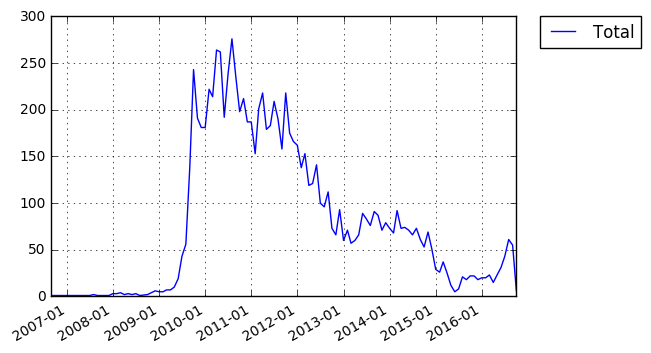


Totals by nativity


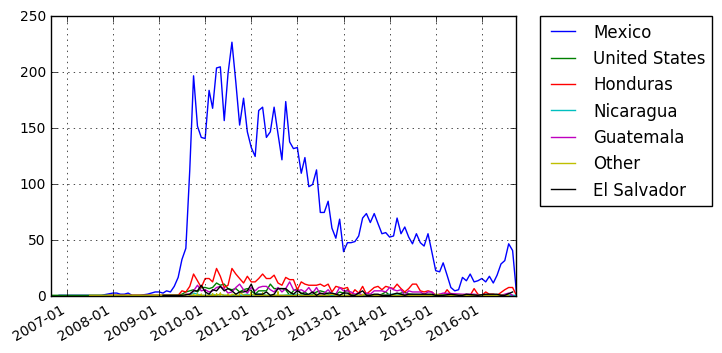


Has at least one felony


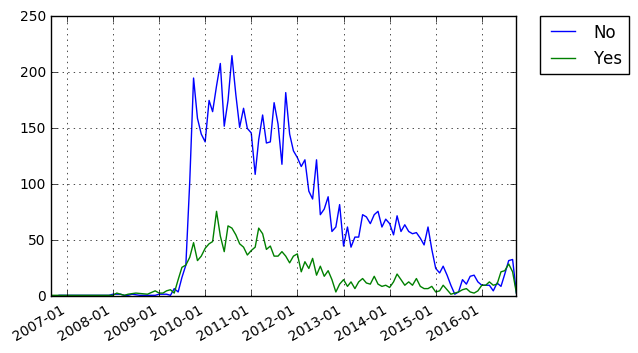


Has multiple felonies


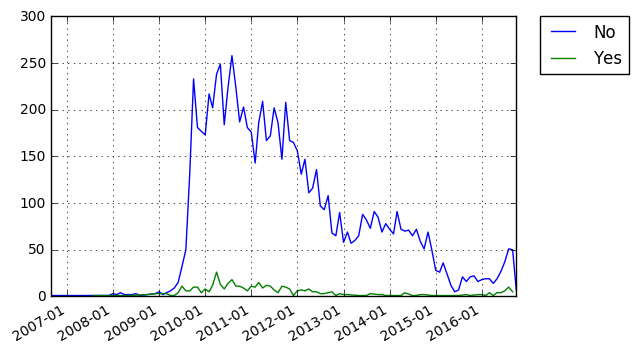


Has only one misdemeanor


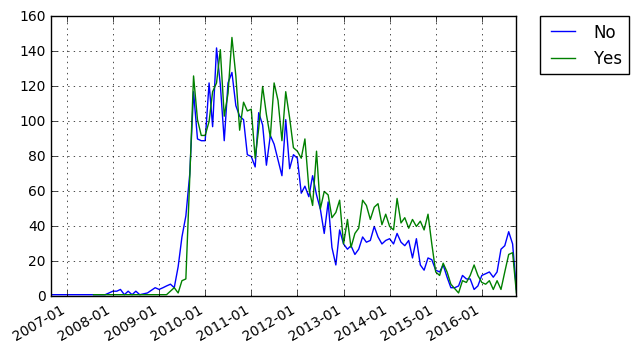


Has at least one violent crime


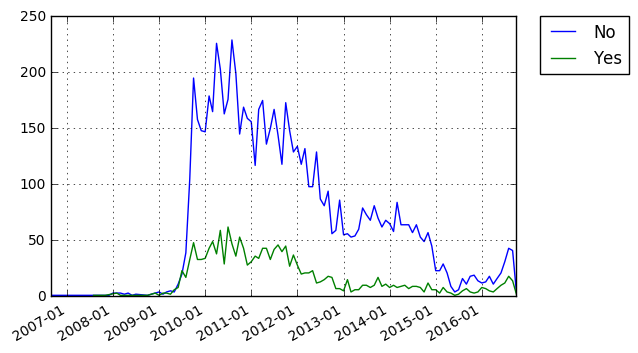


Has multiple violent crimes


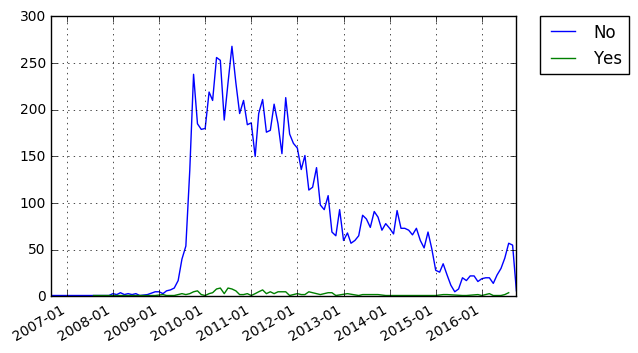

In [11]:
years = YearLocator()
months = MonthLocator()
dateFmt = DateFormatter('%Y-%m')

common_countries = ('Mexico', 'Honduras', 'Guatemala', 'United States',
                    'El Salvador', 'Nicaragua')

total_dict = {'name': 'Totals',
              'data': {'Total': {'dates': [], 'values': []}}}

nativity_dict = {'name': 'Totals by nativity',
                 'data': {'Other':{'dates':[],'values':[]},
                          'Mexico':{'dates':[],'values':[]},
                          'Honduras':{'dates':[],'values':[]},
                          'Guatemala':{'dates':[],'values':[]},
                          'United States':{'dates':[],'values':[]},
                          'El Salvador':{'dates':[],'values':[]},
                          'Nicaragua':{'dates':[],'values':[]}}}

felony_dict = {'name': 'Has at least one felony',
               'data': {'Yes':{'dates':[],'values':[]},
                        'No':{'dates':[],'values':[]}}}

multiple_felony_dict = {'name': 'Has multiple felonies',
                        'data': {'Yes':{'dates':[],'values':[]},
                                 'No':{'dates':[],'values':[]}}}

violent_crime_dict = {'name': 'Has at least one violent crime',
                      'data': {'Yes':{'dates':[],'values':[]},
                               'No':{'dates':[],'values':[]}}}

multiple_violent_crime_dict = {'name': 'Has multiple violent crimes',
                      'data': {'Yes':{'dates':[],'values':[]},
                               'No':{'dates':[],'values':[]}}}

only_one_misd_dict = {'name': 'Has only one misdemeanor',
                      'data': {'Yes':{'dates':[],'values':[]},
                               'No':{'dates':[],'values':[]}}}

grouped_by_booking_month = table.group_by('booking_month_year')

ls_for_summary_table = []

cols_for_summary_table = ['month', 'total', 'has_at_least_one_felony', 'has_at_least_one_violent_crime']

col_types_for_summary_table = [agate.Text(), agate.Number(), agate.Number(), agate.Number()]

for t in grouped_by_booking_month:
    
    ls = []

    b_date = t.select('booking_month_year').rows[0].values()[0]
    ls.append(b_date)

    b_date_split = b_date.split('-')
    
    b_date = datetime.date(int(b_date_split[0]), int(b_date_split[1]), 1)
    
    # totals for this month
    total_dict['data']['Total']['dates'].append(b_date)
    total_dict['data']['Total']['values'].append(len(t.rows)) 
    
    ls.append(len(t.rows))

    # grouped by country of origin
    grouped_by_nativity = t.group_by('nativity')
    nativity_counts = grouped_by_nativity.aggregate([
        ('nativity_count', agate.Count())
    ])
    
    for row in nativity_counts.rows:
        country = row['nativity']
        count = int(row['nativity_count'])
        
        if country in common_countries:        
            rec = nativity_dict['data'].get(country, None)
        else:
            rec = nativity_dict['data'].get('Other', None)
        
        if rec:
            rec['dates'].append(b_date)
            rec['values'].append(count)

    # grouped by felony status
    felony_grouper = t.compute([
        ('felony_status', agate.Formula(agate.Boolean(), lambda row: row['felony'] > 0)),
        ('multiple_felony_status', agate.Formula(agate.Boolean(), lambda row: row['felony'] > 1)),
    ])

    grouped_single_felony = felony_grouper.group_by('felony_status')
    
    for x in grouped_single_felony.dict():

        count = len(grouped_single_felony.dict()[x].rows)

        if x:
            key = 'Yes'
            ls.append(count)
        else:
            key = 'No'

        rec = felony_dict['data'].get(key, None)
        
        if rec:
            rec['dates'].append(b_date)
            rec['values'].append(count)
       
    grouped_multiple_felonies = felony_grouper.group_by('multiple_felony_status')
    
    for x in grouped_multiple_felonies.dict():
        count = len(grouped_multiple_felonies.dict()[x].rows)

        if x:
            key = 'Yes'
        else:
            key = 'No'

        rec = multiple_felony_dict['data'].get(key, None)
        
        if rec:
            rec['dates'].append(b_date)
            rec['values'].append(count)

    # grouped by one-off misdemeanor status
    one_misd_grouper = t.compute([
        ('one_misdemeanor_status', agate.Formula(agate.Boolean(),
                                                 lambda row: row['felony'] == 0 and row['misdemeanor'] == 1))
    ])

    grouped_single_misd = one_misd_grouper.group_by('one_misdemeanor_status')
    
    for x in grouped_single_misd.dict():
        
        if x:
            key = 'Yes'
        else:
            key = 'No'

        count = len(grouped_single_misd.dict()[x].rows)

        rec = only_one_misd_dict['data'].get(key, None)
        
        if rec:
            rec['dates'].append(b_date)
            rec['values'].append(count)

    # grouped by violent crime status
    violent_crime_grouper = t.compute([
        ('violent_crime_status', agate.Formula(agate.Boolean(), lambda row: row['violent_crime'] > 0)),
        ('multiple_violent_crime_status', agate.Formula(agate.Boolean(), lambda row: row['violent_crime'] > 1)),
    ])

    grouped_single_violent_crime = violent_crime_grouper.group_by('violent_crime_status')
    
    for x in grouped_single_violent_crime.dict():
        count = len(grouped_single_violent_crime.dict()[x].rows)

        if x:
            key = 'Yes'
            ls.append(count)
        else:
            key = 'No'

        rec = violent_crime_dict['data'].get(key, None)
        
        if rec:
            rec['dates'].append(b_date)
            rec['values'].append(count)
       
    grouped_multiple_violent_crime = violent_crime_grouper.group_by('multiple_violent_crime_status')
    
    for x in grouped_multiple_violent_crime.dict():
        
        if x:
            key = 'Yes'
        else:
            key = 'No'

        count = len(grouped_multiple_violent_crime.dict()[x].rows)

        rec = multiple_violent_crime_dict['data'].get(key, None)
        
        if rec:
            rec['dates'].append(b_date)
            rec['values'].append(count)
              
    ls_for_summary_table.append(ls)

# load data into an Agate table
summary_table = agate.Table(ls_for_summary_table, cols_for_summary_table,
                            col_types_for_summary_table).order_by('month', reverse=True)

summary_table.to_csv('summary_table.csv')

things_to_chart = [total_dict, nativity_dict, felony_dict,
                   multiple_felony_dict, only_one_misd_dict,
                  violent_crime_dict, multiple_violent_crime_dict]

for thing in things_to_chart:
    fig, ax = plt.subplots()
    for key in thing['data']:
        dates = thing['data'][key]['dates']
        data = thing['data'][key]['values']
        ax.plot_date(dates, data, '-', label=key)

    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(dateFmt)
    ax.autoscale_view()

    ax.fmt_xdata = DateFormatter('%Y-%m-%d')
    ax.grid(True)

    fig.autofmt_xdate()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    print("\n" + thing['name'])
    plt.show()